# Hyper-Parameter Optimization Using Keras on Fashion-MNIST DataSet

## Introduction
The Fashion-MNIST dataset is a collection of images of fashion items, like T-shirts, dresses, shoes etc. It can be used as drop-in replacement for the original MNIST digits dataset as it shares the same image size (28x28x1— grayscale) and has 60,000 training and 10,000 testing images. It has 10 categories of output labels: [0: T-shirt/top, 1:Trouser, 2:Pullover, 3:Dress, 4:Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:Bag, 9:Ankle Boot].

### Imports

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import visualkeras
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.datasets import fashion_mnist
from keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D,
)
from keras.metrics import F1Score
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical, plot_model
from time import time

### Loading the Fashion MNIST DataSet from Keras

In [3]:
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
print(train_data.shape)
print(test_data.shape)

print(train_labels.shape)
print(test_labels.shape)

print(type(train_data))
print(type(test_data))

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Data Visualization

In [5]:
print(test_data[0])
print(test_labels[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   3   1   0   0   7   0  37   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   1   2   

In [6]:
set(test_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

There are 10 classes with the same amount of samples in the fashion_mnist dataset. Let's print their random examples.

In [7]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

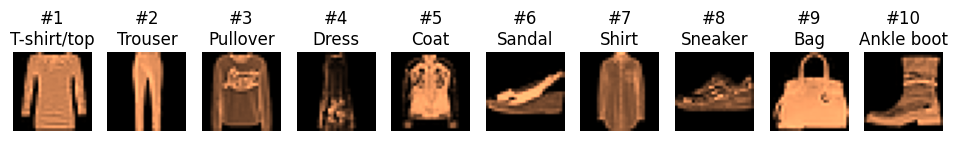

In [8]:
sorter = np.argsort(test_labels)
numbers = np.array([i for i in range(10)])
indices = sorter[np.searchsorted(test_labels, numbers, sorter=sorter)]
test_images = test_data[indices]

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(test_images[i].reshape((28, 28)), cmap="copper")
    plt.title(f"#{i+1}\n{class_names[i]}")
    plt.axis("off")
plt.show()

## Study
In this section, the selection of optimal hyperparameters will be carried out on a simple model composed only of Dense layers whose quantity can vary from 3 to 5.

### Data Normalization

In [9]:
train_norm = train_data.astype("float32") / 255
test_norm = test_data.astype("float32") / 255

train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

### Plotter of Learning Curves

In [10]:
def plot_results(history):
    history_dict = history.history

    epochs = range(1, len(history_dict["accuracy"]) + 1)

    plt.plot(epochs, history_dict["loss"], "bo", label="Training loss")
    plt.plot(epochs, history_dict["val_loss"], "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.plot(epochs, history_dict["accuracy"], "bo", label="Training acc"),
    plt.plot(epochs, history_dict["val_accuracy"], "b", label="Validation acc")
    plt.title("Training and validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

    plt.plot(epochs, np.mean(history_dict["f1_score"], axis=1), "bo", label="Training F1 Score")
    plt.plot(epochs, np.mean(history_dict["val_f1_score"], axis=1), "b", label="Validation F1 Score")
    plt.title("Training and validation F1 Score")
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

### Plotter of Model's Score

In [11]:
def plot_score(total_results, per_class_accuracy, time_delta):
    print(f"\nDuration -> {time_delta:.1f}s")

    print("|__Metric__", end="")
    for i in range(10):
        print(f"|___{i}___", end="")
    print("|_Total_|")

    print(f"|_F1_Score_", end="|")
    for i in range(10):
        print(f"_{np.mean(total_results[2][i])*100:.1f}%_", end="|")
    print(f"_{np.mean(total_results[2])*100:.1f}%_|")

    print("|_Accuracy_", end="|")
    for i in range(10):
        print(f"_{per_class_accuracy[i]*100:.1f}%_", end="|")
    print(f"_{np.mean(total_results[1])*100:.1f}%_|")

### Model Evaluator
By default, it contains very simple hyperparameters that will be optimized in the process.

In [12]:
def evaluate_model(model, epochs=40, batch_size=128):
    start = time()

    history = model.fit(
        x=train_norm,
        y=train_labels,
        epochs=epochs,
        verbose=1,
        batch_size=batch_size,
        validation_data=(test_norm, test_labels),
    )

    results = model.evaluate(test_norm, test_labels)

    time_delta = time() - start

    per_class_accuracy = []
    for i in range(10):
        res = model.evaluate(test_norm[test_labels.argmax(axis=1) == i], test_labels[test_labels.argmax(axis=1) == i])
        per_class_accuracy.append(res[1])

    plot_score(results, per_class_accuracy, time_delta)

    plot_results(history)

    return history

## Convolutional Neural Network

### Model with 4 Conv2D Layers + 2 Dense Layers

In [94]:
def construct_model_1(
    optimizer=Adam,
    learning_rate=0.001,
    activation="relu",
    dropout_rate=0.3,
    initializer="he_normal",
    units_l1=32,
    units_l2=64,
    units_l3=128,
    units_l4=128,
    units_l5=512,
):
    model = Sequential(name="CNN")

    model.add(
        Conv2D(
            units_l1,
            3,
            padding="same",
            activation=activation,
            kernel_initializer=initializer,
            input_shape=(train_data[0].shape[0], train_data[0].shape[1], 1),
            name="Conv_1",
        )
    )
    model.add(MaxPooling2D(pool_size=(2, 2), name="Pooling_1"))

    model.add(Conv2D(units_l2, 3, padding="same", activation=activation, name="Conv_2"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="Pooling_2"))

    model.add(Dropout(dropout_rate, name="Dropout_1"))
    model.add(BatchNormalization(name="BatchNorm_1"))
    model.add(Conv2D(units_l3, 3, padding="same", activation=activation, name="Conv_3"))
    model.add(Conv2D(units_l4, 3, padding="same", activation=activation, name="Conv_4"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="Pooling_3"))

    model.add(Dropout(dropout_rate, name="Dropout_2"))
    model.add(Flatten())
    model.add(BatchNormalization(name="BatchNorm_2"))
    model.add(Dense(units_l5, activation=activation, name="Dense_1"))

    model.add(Dropout(dropout_rate, name="Dropout_3"))
    model.add(Dense(10, activation="softmax", name="Dense_Output"))

    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer(learning_rate=learning_rate),
        metrics=["accuracy", F1Score()],
    )
    return model

Epoch 1/40
469/469 [==============================] - 17s 17ms/step - loss: 0.5247 - accuracy: 0.8114 - f1_score: 0.8106 - val_loss: 0.3648 - val_accuracy: 0.8621 - val_f1_score: 0.8604
Epoch 2/40
469/469 [==============================] - 4s 9ms/step - loss: 0.3532 - accuracy: 0.8702 - f1_score: 0.8696 - val_loss: 0.3519 - val_accuracy: 0.8720 - val_f1_score: 0.8734
Epoch 3/40
469/469 [==============================] - 6s 13ms/step - loss: 0.3112 - accuracy: 0.8837 - f1_score: 0.8833 - val_loss: 0.2739 - val_accuracy: 0.8990 - val_f1_score: 0.9003
Epoch 4/40
469/469 [==============================] - 4s 9ms/step - loss: 0.2824 - accuracy: 0.8947 - f1_score: 0.8944 - val_loss: 0.2644 - val_accuracy: 0.9023 - val_f1_score: 0.9019
Epoch 5/40
469/469 [==============================] - 4s 9ms/step - loss: 0.2662 - accuracy: 0.9016 - f1_score: 0.9013 - val_loss: 0.2606 - val_accuracy: 0.9034 - val_f1_score: 0.9047
Epoch 6/40
469/469 [==============================] - 5s 11ms/step - loss: 0.

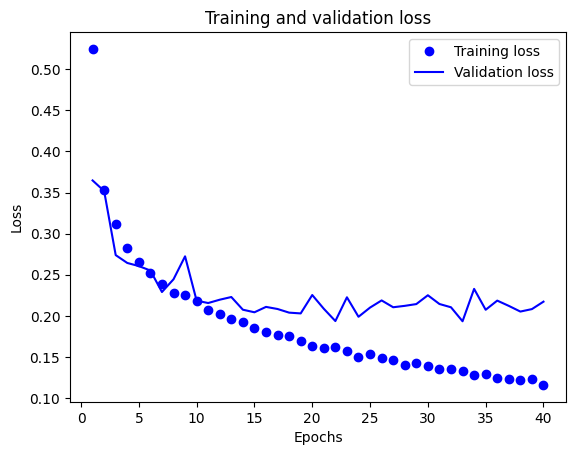

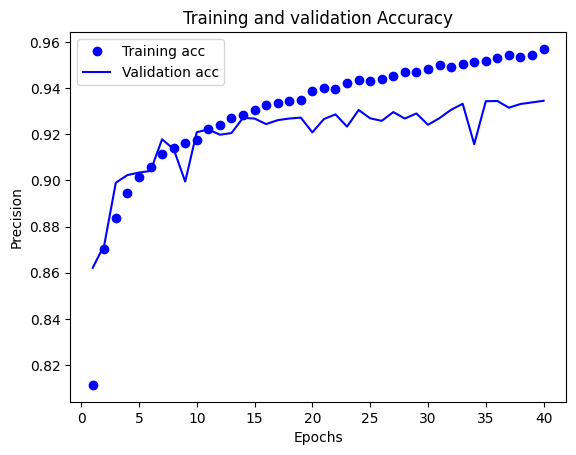

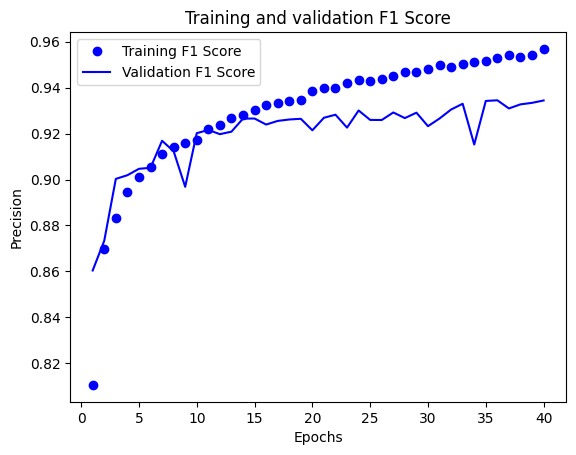

In [14]:
model_1 = construct_model_1()
evaluate_model(model_1, epochs=40)

### Visualization of the Neural Network Architecture

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 Pooling_1 (MaxPooling2D)    (None, 14, 14, 32)        0         
                                                                 
 Conv_2 (Conv2D)             (None, 14, 14, 64)        18496     
                                                                 
 Pooling_2 (MaxPooling2D)    (None, 7, 7, 64)          0         
                                                                 
 Dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 BatchNorm_1 (BatchNormaliz  (None, 7, 7, 64)          256       
 ation)                                                          
                                                               

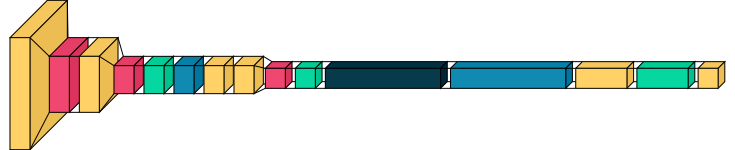

In [96]:
model_1.summary()
visualkeras.layered_view(model_1)

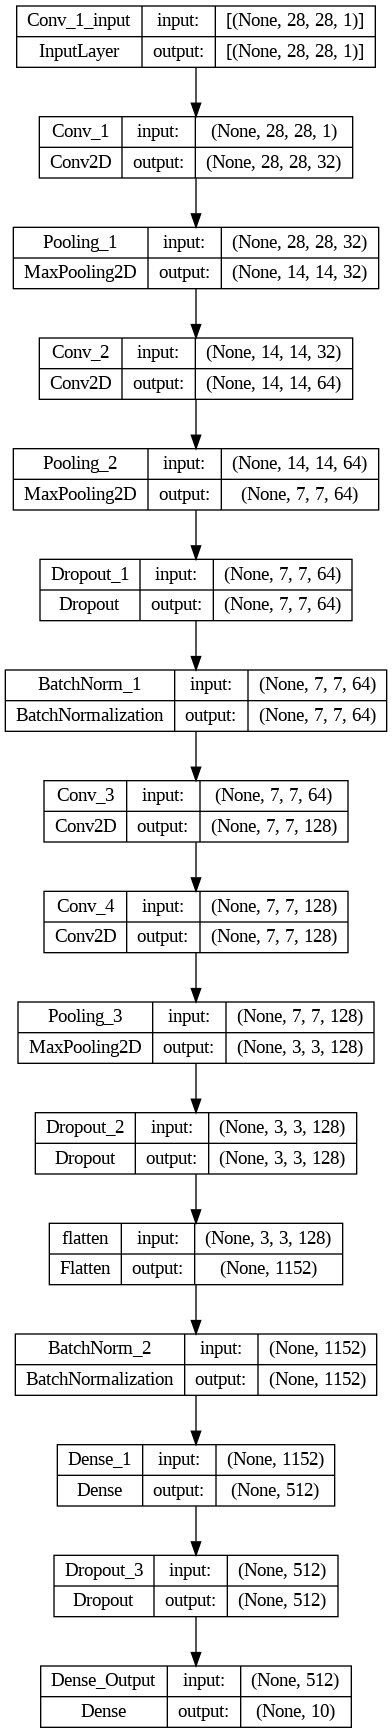

In [16]:
plot_model(model_1, to_file="model_1.png", show_shapes=True)

### Model Weights

In [17]:
weights = model_1.get_weights()
weights

[array([[[[-7.23098278e-01,  4.39228982e-01,  3.59785348e-01,
            1.22436070e+00, -2.29664072e-01, -2.01775193e-01,
           -1.26967001e+00, -1.44571769e+00,  4.65008169e-02,
           -9.38436210e-01, -4.93283063e-01, -4.66161221e-01,
            1.69480368e-01, -1.19628899e-01,  4.19927925e-01,
           -8.99099588e-01,  4.89441417e-02, -3.97836268e-01,
            2.38057733e-01,  1.89663202e-01,  1.01047963e-01,
            7.55661950e-02,  1.75353646e-01, -2.39266083e-01,
           -9.61035609e-01, -4.93392721e-02,  5.56031227e-01,
            8.79086733e-01, -4.00393963e-01,  7.67907023e-01,
           -5.23865044e-01, -3.17539632e-01]],
 
         [[-4.61610079e-01, -5.30263066e-01, -7.83369839e-01,
           -8.30213845e-01, -1.72921658e+00, -9.54192877e-01,
           -7.95383692e-01,  6.03973329e-01,  3.86457086e-01,
           -3.07948112e-01,  9.61967483e-02,  8.78890276e-01,
            7.37479627e-01,  1.30483881e-01,  2.50459701e-01,
            2.1919798

### Model Serialization to JSON

In [18]:
model_json = model_1.to_json()
with open("model_1.json", "w") as fd:
    fd.write(model_json)

### Saving Model

In [52]:
model_1.save("source/model_1")

In [62]:
model_1.save("source/model_1.keras") # zipped model

## Convolutional NN with VGG16 Model

### Resizing Input Images
VGG15 requires as input format at least (32, 32, 3) instead of fashion_mnist (28, 28, 1) type.

In [19]:
train_norm = tf.image.grayscale_to_rgb(tf.expand_dims(train_norm, axis=3))
test_norm = tf.image.grayscale_to_rgb(tf.expand_dims(test_norm, axis=3))

train_norm = tf.image.resize_with_pad(train_norm, 32, 32)
test_norm = tf.image.resize_with_pad(test_norm, 32, 32)

In [20]:
print(train_norm.shape)
print(test_norm.shape)

(60000, 32, 32, 3)
(10000, 32, 32, 3)


### Model with VGG16 (Non-Trainable) + 2 Dense Layers

In [97]:
def construct_model_2(
    optimizer=Adam,
    learning_rate=0.001,
    activation="relu",
    dropout_rate=0.3,
    train_base=False,
    units_l1=512,
):
    conv_base = VGG16(
        weights="imagenet",
        include_top=False,
        input_shape=(32, 32, 3),
    )
    conv_base.trainable = train_base
    if train_base == True:
        set_trainable = False
        for layer in conv_base.layers:
            if layer.name == "block5_conv1":
                set_trainable = True
            if set_trainable:
                layer.trainable = True
            else:
                layer.trainable = False

    model = Sequential(name="VGG16")
    model.add(conv_base)

    model.add(Dropout(dropout_rate, name="Dropout_1"))
    model.add(Flatten())
    model.add(Dense(units_l1, activation=activation, name="Dence_1"))

    model.add(Dropout(dropout_rate, name="Dropout_2"))
    model.add(Dense(10, activation="softmax", name="Dense_Output"))

    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer(learning_rate=learning_rate),
        metrics=["accuracy", F1Score()],
    )
    return model, conv_base

In [32]:
model_2, conv_base = construct_model_2()

In [33]:
model_2.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 Dropout_1 (Dropout)         (None, 1, 1, 512)         0         
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 Dence_1 (Dense)             (None, 512)               262656    
                                                                 
 Dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 Dense_Output (Dense)        (None, 10)                5130      
                                                                 
Total params: 14982474 (57.15 MB)
Trainable params: 267786 (1

In [34]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

Epoch 1/40
469/469 [==============================] - 12s 24ms/step - loss: 0.7102 - accuracy: 0.7460 - f1_score: 0.7444 - val_loss: 0.4951 - val_accuracy: 0.8220 - val_f1_score: 0.8221
Epoch 2/40
469/469 [==============================] - 11s 23ms/step - loss: 0.5512 - accuracy: 0.7984 - f1_score: 0.7974 - val_loss: 0.4558 - val_accuracy: 0.8334 - val_f1_score: 0.8319
Epoch 3/40
469/469 [==============================] - 11s 23ms/step - loss: 0.5133 - accuracy: 0.8096 - f1_score: 0.8085 - val_loss: 0.4292 - val_accuracy: 0.8432 - val_f1_score: 0.8424
Epoch 4/40
469/469 [==============================] - 10s 22ms/step - loss: 0.4920 - accuracy: 0.8193 - f1_score: 0.8185 - val_loss: 0.4211 - val_accuracy: 0.8423 - val_f1_score: 0.8394
Epoch 5/40
469/469 [==============================] - 10s 22ms/step - loss: 0.4750 - accuracy: 0.8241 - f1_score: 0.8232 - val_loss: 0.4113 - val_accuracy: 0.8481 - val_f1_score: 0.8490
Epoch 6/40
469/469 [==============================] - 10s 22ms/step - 

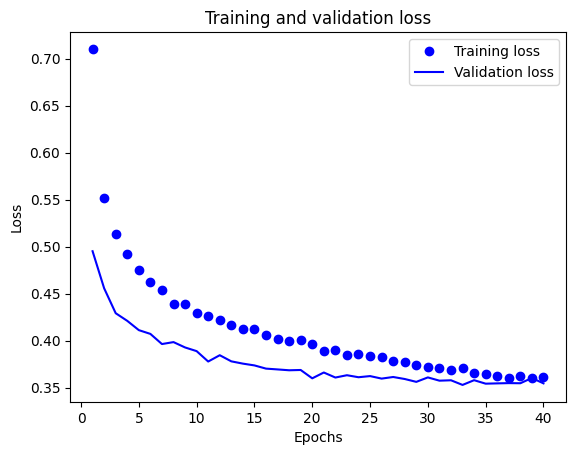

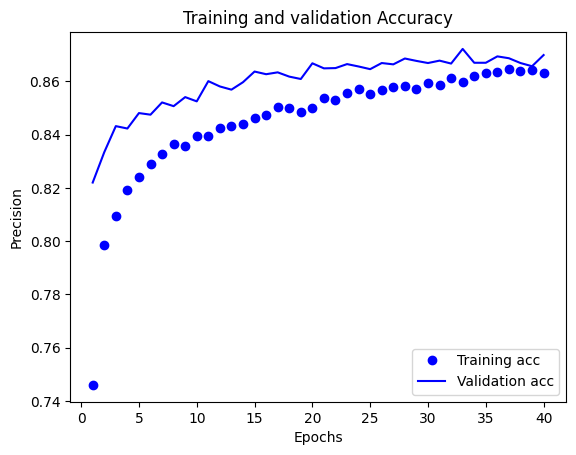

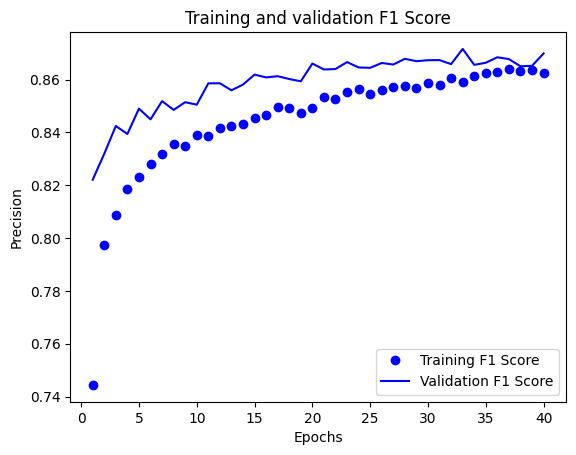

In [35]:
evaluate_model(model_2, epochs=40)

In [98]:
model_2a, conv_base_a = construct_model_2(train_base=True, learning_rate=0.0005)

### Summary of VGG16 CNN Model with additional Dense Layers

In [99]:
model_2a.summary()
visualkeras.layered_view(model_2a)

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 Dropout_1 (Dropout)         (None, 1, 1, 512)         0         
                                                                 
 flatten_10 (Flatten)        (None, 512)               0         
                                                                 
 Dence_1 (Dense)             (None, 512)               262656    
                                                                 
 Dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 Dense_Output (Dense)        (None, 10)                5130      
                                                                 
Total params: 14982474 (57.15 MB)
Trainable params: 7347210 (

### Summary of VGG16 Base

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

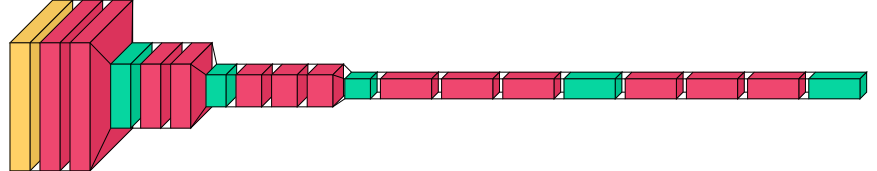

In [100]:
conv_base_a.summary()
visualkeras.layered_view(conv_base_a)

Epoch 1/40
469/469 [==============================] - 17s 32ms/step - loss: 0.4426 - accuracy: 0.8424 - f1_score: 0.8419 - val_loss: 0.3306 - val_accuracy: 0.8836 - val_f1_score: 0.8839
Epoch 2/40
469/469 [==============================] - 14s 31ms/step - loss: 0.3091 - accuracy: 0.8893 - f1_score: 0.8890 - val_loss: 0.2987 - val_accuracy: 0.8907 - val_f1_score: 0.8882
Epoch 3/40
469/469 [==============================] - 14s 31ms/step - loss: 0.2684 - accuracy: 0.9037 - f1_score: 0.9034 - val_loss: 0.2789 - val_accuracy: 0.8985 - val_f1_score: 0.8985
Epoch 4/40
469/469 [==============================] - 14s 30ms/step - loss: 0.2503 - accuracy: 0.9086 - f1_score: 0.9084 - val_loss: 0.2761 - val_accuracy: 0.9027 - val_f1_score: 0.9027
Epoch 5/40
469/469 [==============================] - 14s 30ms/step - loss: 0.2324 - accuracy: 0.9158 - f1_score: 0.9156 - val_loss: 0.2710 - val_accuracy: 0.9098 - val_f1_score: 0.9097
Epoch 6/40
469/469 [==============================] - 14s 30ms/step - 

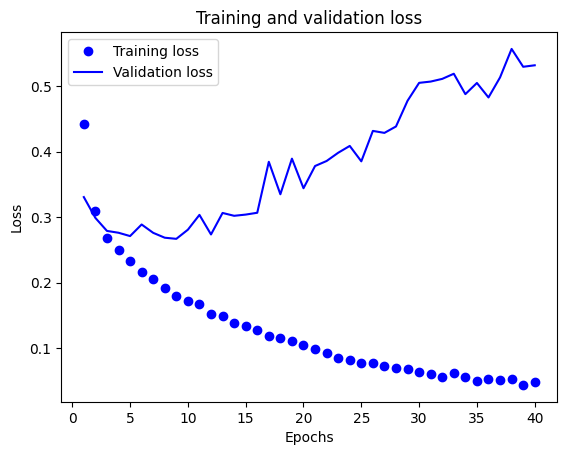

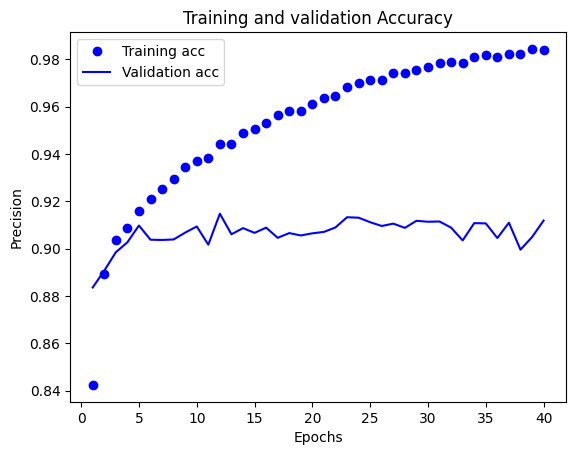

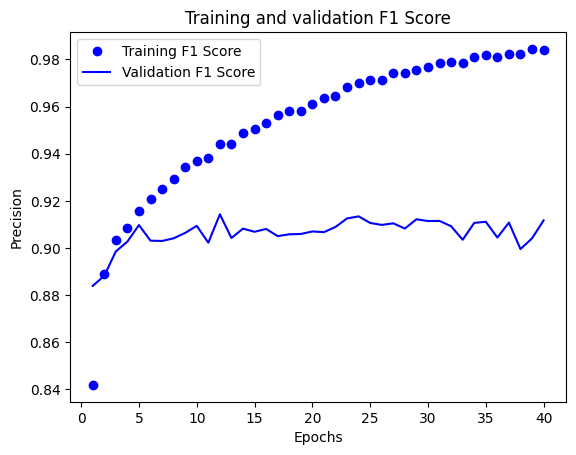

In [47]:
evaluate_model(model_2a, epochs=40)

### Saving Model

In [55]:
model_2a.save("source/model_2")
conv_base_a.save("source/model_2_base")

### Visualization of Model's Architecture

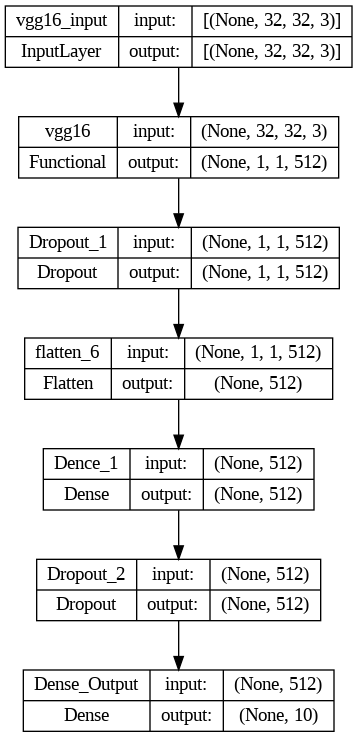

In [53]:
plot_model(model_2a, to_file="source/model_2.png", show_shapes=True)

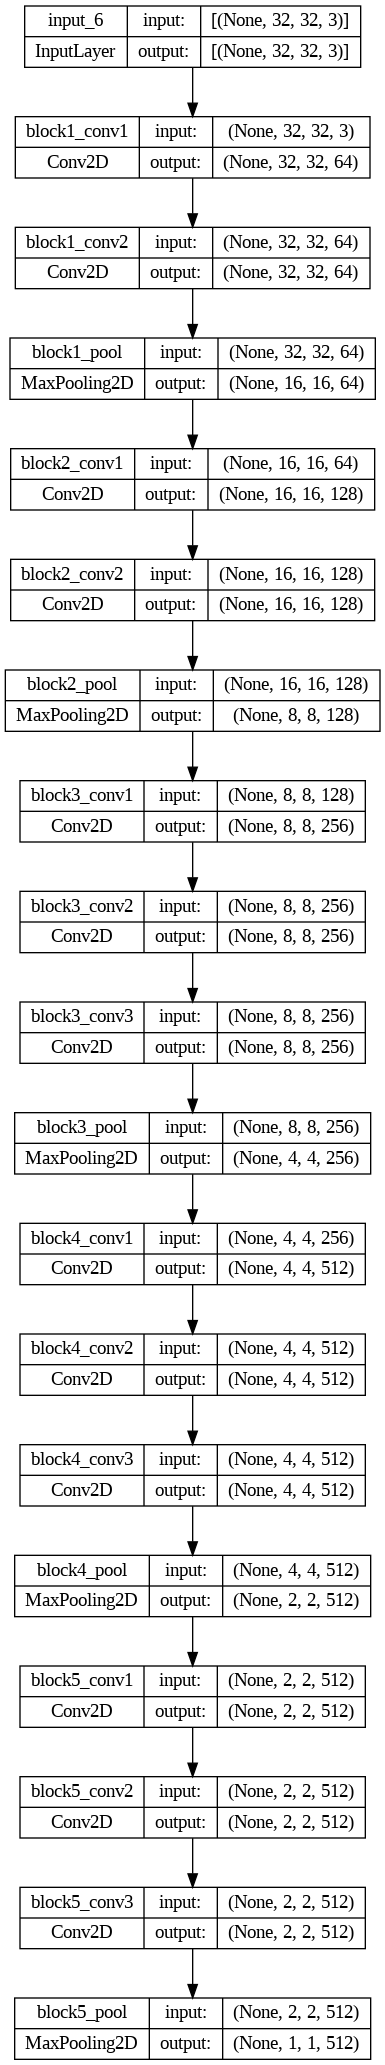

In [54]:
plot_model(conv_base_a, to_file="source/model_2_base.png", show_shapes=True)

## Conclusion
Based on the research conducted in this work, it can be concluded that CNN models cope with image recognition much better than fully connected ones. The CNN model shows 93.5% Accuracy and F1 Score after 40 epochs and tries to reach 94% after 100 epochs, while fully connected only tries to reach 91%.

Regarding the VGG16 based models, the trainable base model shows results (91.2% Accuracy and F1) much better than the untrainable one and better than the fully connected model, but inferior to the custom CNN and it's also much slower.